# aSPEM Experiment : analysis



TODO: clean-up garder blocs indep full R

TODO: moulinette statistique ? https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://en.wikipedia.org/wiki/Earth_mover%27s_distance

TODO: https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [5]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [6]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [7]:
def print_stat(h, age) :
    from scipy import stats
    
    print('\n\t\t\tmannwhitneyu', '\tkruskal', '\t\tks_2samp', sep='')
    print('\t\t\t','-'*12, '\t', '-'*7, '\t\t', '-'*8, sep='')
    
    def stata(h1, h2) :
        man = stats.mannwhitneyu(h1, h2).pvalue
        kr = stats.kruskal(h1, h2).pvalue
        ks = stats.ks_2samp(h1, h2).pvalue
        print('%.4f'%man, '%.4f'%kr, '%.4f'%ks, sep='\t\t')
              #'\nwasserstein_distance (Earth movers distance) : ',
              #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
        return man, kr, ks
    
    
    list_signi = []
    
    print('H vs F', end=' :\t\t')
    man, kr, ks = stata(h['F'], h['M'])
    for s in [man, kr, ks] :
        if s < 0.05 : list_signi.append('H vs F') ; break
    
    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' :\t\t')
                man, kr, ks = stata(h['b'][b1], h['b'][b2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('BLOCK %s vs %s'%(b1,b2)) ; break
                

    for a1 in age[:2] :
        for a2 in age[1:] :
            if a1!=a2 :
                print('AGE %s vs %s'%(a1,a2), end=' :\t')
                man, kr, ks = stata(h[a1], h[a2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('AGE %s vs %s'%(a1,a2)) ; break
                
    print('TIME a.m vs p.m', end=' :\t')
    man, kr, ks = stata(h['a.m'], h['p.m'])
    for s in [man, kr, ks] :
        if s < 0.05 : list_signi.append('TIME a.m vs p.m') ; break
    
    print('\nSignificatif :', list_signi)

In [8]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

list_suj = {'AM': 'F', 'BMC': 'M', 'CS': 'F', 'DC': 'F',
            'FM': 'F', 'IP': 'F',  'LB': 'F', 'OP': 'M',
            'RS': 'M', 'SR': 'F',  'TN': 'M', 'YK': 'M'}

age_suj = {'AM': 44, 'BMC': 24, 'CS': 28, 'DC': 27,
           'FM': 30, 'IP': 26,  'LB': 27, 'OP': 31,
           'RS': 28, 'SR': 25,  'TN': 28, 'YK': 30}

# 2 sujet -25  # 6 sujet 26-29 # 4 sujets 30-
# 3 sujet -26  # 5 sujet 27-29 # 4 sujets 30-
age=['-26', '27-29', '30-']
for s in age_suj.keys() :
    if age_suj[s]<=26 :   age_suj[s]='-26'
    elif age_suj[s]<=29 : age_suj[s]='27-29'
    else :                age_suj[s]='30-'
        
        
time_va = {'AM': 'a.m', 'BMC': 'a.m', 'CS': 'p.m', 'DC': 'p.m',
           'FM': 'p.m', 'IP': 'a.m',  'LB': 'p.m', 'OP': 'a.m',
           'RS': 'a.m', 'SR': 'p.m',  'TN': 'p.m', 'YK': 'p.m'}

time_bet = {'AM': 'a.m', 'BMC': 'p.m', 'CS': 'p.m', 'DC': 'p.m',
            'FM': 'p.m', 'IP': 'a.m',  'LB': 'p.m', 'OP': 'a.m',
            'RS': 'a.m', 'SR': 'a.m',  'TN': 'p.m', 'YK': 'p.m'}

In [9]:
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=0.99, triangle=True, age=age) :
    
    if triangle is True : from matplotlib.patches import Polygon
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    c_block = ['olive', 'peru', 'brown']
    c_s = ['crimson', 'teal']
    
    
    fig = plt.figure(figsize=(15,15))
    import matplotlib.gridspec as gridspec
    #gs = gridspec.GridSpec(5, 5)
    #'''ax_ = plt.subplot(gs[1:5, :4])
    #ax_x, ax_y = plt.subplot(gs[0, :4]), plt.subplot(gs[1:5, 4])'''

    gs = gridspec.GridSpec(9, 9)
    ax_ = plt.subplot(gs[4:, :5])
    ax_x,  ax_y  = plt.subplot(gs[3, :5]), plt.subplot(gs[4:, 5])
    ax_x1, ax_y1 = plt.subplot(gs[2, :5]), plt.subplot(gs[4:, 6])
    ax_x2, ax_y2 = plt.subplot(gs[1, :5]), plt.subplot(gs[4:, 7])
    ax_x3, ax_y3 = plt.subplot(gs[0, :5]), plt.subplot(gs[4:, 8])

    
    # DECO
    #---------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '-k', alpha=0.5, lw=1)
    opt=dict(colors='k', linestyles='-', alpha=0.4)
    ax_.vlines(0.025, 0, 0.025, **opt) ; ax_.hlines(0.025, 0, 0.025, **opt)
    ax_.set_xlabel('$h_{va}$', fontsize=20) ; ax_.set_ylabel('$h_{bet}$', fontsize=20)
    
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    ax_xC, ax_yC = ax_x.twinx(), ax_y.twiny()
    ax_x1C, ax_y1C, ax_x2C, ax_y2C, ax_x3C, ax_y3C = ax_x1.twinx(), ax_y1.twiny(), ax_x2.twinx(), ax_y2.twiny(), ax_x3.twinx(), ax_y3.twiny()
    
    for a,l in zip([ax_xC,ax_x1C,ax_x2C,ax_x3C], ['H vs F','Block','age','time']) : a.set_ylabel(l,color='k') ; a.tick_params('y',colors='r')
    for a,l in zip([ax_yC,ax_y1C,ax_y2C,ax_y3C], ['H vs F','Block','age','time']) : a.set_xlabel(l,color='k') ; a.tick_params('x',colors='r')
    
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xC, ax_x1, ax_x1C, ax_x2, ax_x2C, ax_x3, ax_x3C] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yC, ax_y1, ax_y1C, ax_y2, ax_y2C, ax_y3, ax_y3C] : a.set_ylim(lim) ; a.set_yticks(())

    #axis_r = [min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100,
    #          min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100]
    
    #---------------------------------------------------------------
    h_va, h_bet, r_va, r_bet = {}, {}, {}, {}
    for l in [h_va, h_bet, r_va, r_bet] :
        l['full'], l['b'] = [], [[],[],[]]
        for s in ['F', 'M'] : l[s]=[]
        for a in age :        l[a]=[]
        for t in ['a.m', 'p.m'] : l[t]=[]
        
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        if list_suj[s]=='F' : coco=c_s[0]
        else :                coco=c_s[1]
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None :
                #pourcentage
                #-----------------------------------------------------------------------
                if np.argmax(r_va_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_va_d, pourcentage)
                    r_va_s.append(r_va_d[maxx]) ; h_va_s.append(list_h[maxx])
                else : r_va_s.append(np.max(r_va_d)) ; h_va_s.append(list_h[np.argmax(r_va_d)])

                if np.argmax(r_bet_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_bet_d, pourcentage)
                    r_bet_s.append(r_bet_d[maxx])   ; h_bet_s.append(list_h[maxx])
                else : r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                #-----------------------------------------------------------------------
            else :
                r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)])
                r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                
            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        #-----------------------------------------------------------------------
        if triangle is True :
            tritri = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
            popo = Polygon(tritri, edgecolor=coco, alpha=0.4, lw=1.2, facecolor='none') # color=COLOR[num]
            ax_.add_artist(popo)
        
        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.5, lw=0, edgecolors=coco) # c=COLOR[num], lw=3
        if s in ['TN', 'LB'] :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        marker='*', c=c_block[:1], zorder=100, lw=0.5, edgecolors='k')
        else :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        c=c_block[:1], zorder=50, **opt)

        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*600,
                    c=c_block[1:], zorder=50, **opt)
        
        #-----------------------------------------------------------------------
        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)
        
        h_va[time_va[s]].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
        h_bet[time_bet[s]].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
        r_va[time_va[s]].extend(r_va_s)
        r_bet[time_bet[s]].extend(r_bet_s)
    
        
        
        
        for arg in [list_suj[s], age_suj[s]] :
            h_va[arg].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
            h_bet[arg].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
            r_va[arg].extend(r_va_s)
            r_bet[arg].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])

    #--------------------------------------------------------------------------------------------
    # HISTOGRAMME
    #--------------------------------------------------------------------------------------------
    c_age = ['m', 'c', 'dimgrey']
    
    opt = dict(range=(np.log(min(list_h)), np.log(max(list_h))), bins=20, alpha=0.3)
    opt_c = dict(range=(np.log(min(list_h)-min(list_h)/9), np.log(max(list_h)+max(list_h)/9)),
                 bins=len(list_h), cumulative=True, histtype='step', align='mid', lw=1.5, density=True)
    
    # hist VA
    #--------------------------------------------------------------------
    for a_x, a_xC in zip([ax_x, ax_x1, ax_x2, ax_x3], [ax_xC, ax_x1C, ax_x2C, ax_x3C]) :
        a_x.hist(np.log(h_va['full']), weights=r_va['full'], color='dimgrey', **opt)
        a_xC.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt_c)
    
    for a, o in zip([ax_x, ax_xC], [opt, opt_c]) :
        a.hist([np.log(h_va['F']), np.log(h_va['M'])], weights=[r_va['F'], r_va['M']], color=c_s,
               label=['F', 'M'], **o)
    
    for a, o in zip([ax_x3, ax_x3C], [opt, opt_c]) :
        a.hist([np.log(h_va['a.m']), np.log(h_va['p.m'])], weights=[r_va['a.m'], r_va['p.m']], color=['r', 'g'],
               label=['a.m', 'p.m'], **o)
    
    
    for AX, o in zip([[ax_x1, ax_x2], [ax_x1C, ax_x2C]], [opt, opt_c]) :
        for a, hv, rv, c in zip(AX, [h_va['b'], [h_va[a] for a in age]], [r_va['b'], [r_va[a] for a in age]], [c_block, c_age]) :
            a.hist([np.log(hv[0]), np.log(hv[1]), np.log(hv[2])], weights=[rv[0], rv[1], rv[2]], color=c,
                   label=[0, 1, 2] if c==c_block else age, **o)
    
    # hist BET
    #--------------------------------------------------------------------
    opt['orientation'], opt_c['orientation'] = "horizontal", "horizontal"
    
    for a_y, a_yC in zip([ax_y, ax_y1, ax_y2, ax_y3], [ax_yC, ax_y1C, ax_y2C, ax_y3C]) :
        a_y.hist(np.log(h_bet['full']), weights=r_bet['full'], color='dimgrey', **opt)
        a_yC.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt_c)
        
    for a, o in zip([ax_y, ax_yC], [opt, opt_c]) :
        a.hist([np.log(h_bet['F']), np.log(h_bet['M'])],weights=[r_bet['F'], r_bet['M']], color=c_s, 
               label=['F', 'M'], **o)
    
    for a, o in zip([ax_y3, ax_y3C], [opt, opt_c]) :
        a.hist([np.log(h_bet['a.m']), np.log(h_bet['p.m'])],weights=[r_bet['a.m'], r_bet['p.m']], color=['r', 'g'], 
               label=['a.m', 'p.m'], **o)
    
    
    
    for AX, o in zip([[ax_y1, ax_y2], [ax_y1C, ax_y2C]], [opt, opt_c]) :
        for a, hv, rv, c in zip(AX, [h_bet['b'], [h_bet[a] for a in age]], [r_bet['b'], [r_bet[a] for a in age]], [c_block, c_age]) :
            a.hist([np.log(hv[0]), np.log(hv[1]), np.log(hv[2])], weights=[rv[0], rv[1], rv[2]], color=c,
                   label=[0, 1, 2] if c==c_block else age, **o)
    #--------------------------------------------------------------------
    
    for c in coupe :
        opt=dict(colors='r', linestyles='--', alpha=0.3, lw=1)
        ax_.vlines(c, 0, 10, **opt) ; ax_.hlines(c, 0, 10, **opt)
    
    
    ax_y.legend() ; ax_y1.legend() ; ax_y2.legend() ; ax_y3.legend()
    ax_x.legend() ; ax_x1.legend() ; ax_x2.legend() ; ax_x3.legend()
    
    plt.show()
    
    #--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*64,'\n%s\n'%title, '-'*64, sep='')        
        print_stat(h, age)

        for c in coupe :
            print('\n\nCoupe à h=%.3f, tau=%.f\n'%(c, 1/c), '-'*24, sep='')

            full_h = [h['F'], h['M'], h['b'][0], h['b'][1], h['b'][2], h['a.m'], h['p.m']]
            full_h.extend(h[a] for a in age)
            
            for h_g in full_h :
                g=0
                while g < len(h_g) :
                    if h_g[g] < c : del h_g[g]
                    else :          g=g+1

            print_stat(h, age)
    #--------------------------------------------------------------------------------------------
        
    return fig

In [10]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

AM BMC CS DC FM IP LB OP RS SR TN YK 

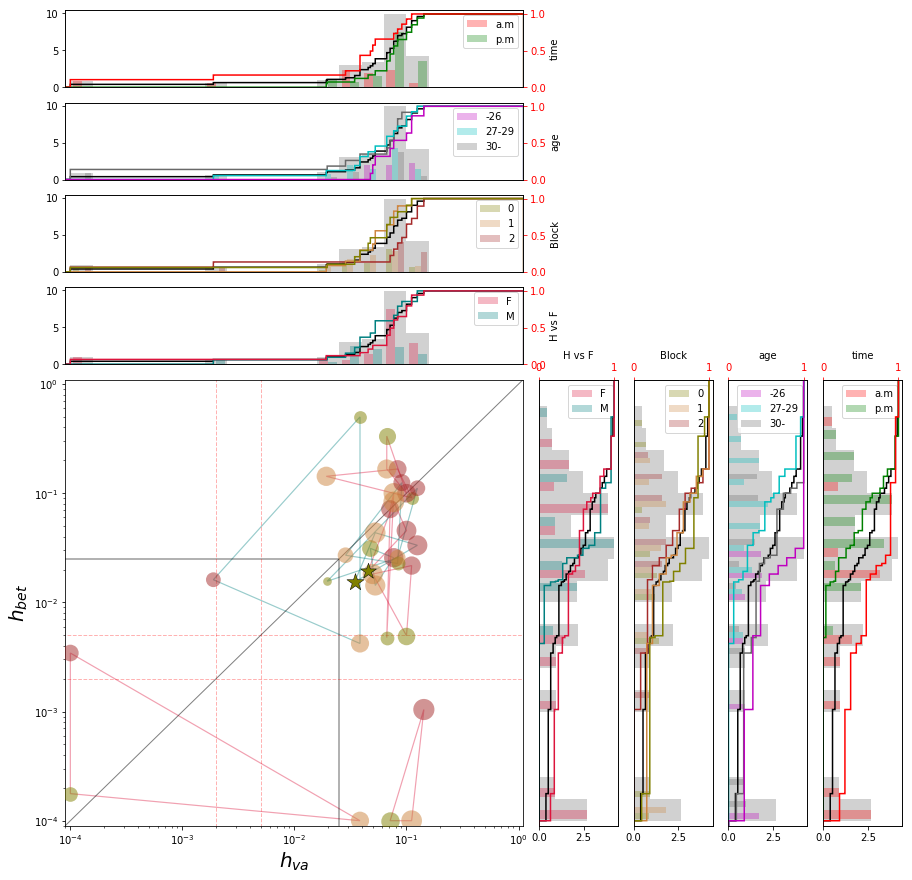



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1756		0.3430		0.2886
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0230		0.0429		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995
AGE -26 vs 27-29 :	0.0846		0.1600		0.2653
AGE -26 vs 30- :	0.0826		0.1545		0.2681
AGE 27-29 vs 30- :	0.3388		0.6598		0.9059
TIME a.m vs p.m :	0.0206		0.0397		0.0582

Significatif : ['BLOCK 0 vs 2', 'BLOCK 1 vs 2', 'TIME a.m vs p.m']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1039		0.2013		0.1920
BLOCK 0 vs 1 :		0.4145		0.8050		0.9992
BLOCK 0 vs 2 :		0.0024		0.0042		0.0112
BLOCK 1 vs 2 :		0.0008		0.0015		0.0067
AGE -26 vs 27-29 :	0.1212		0.2300		0.3759
AGE -26 vs 30- :	0.1952		0.3683		0.5386
AGE 27-29 vs 30- :	0.4883		0.9532		0.9675
TIME a.m vs p.m 

In [11]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None)

AM BMC CS DC FM IP LB OP RS SR TN YK 

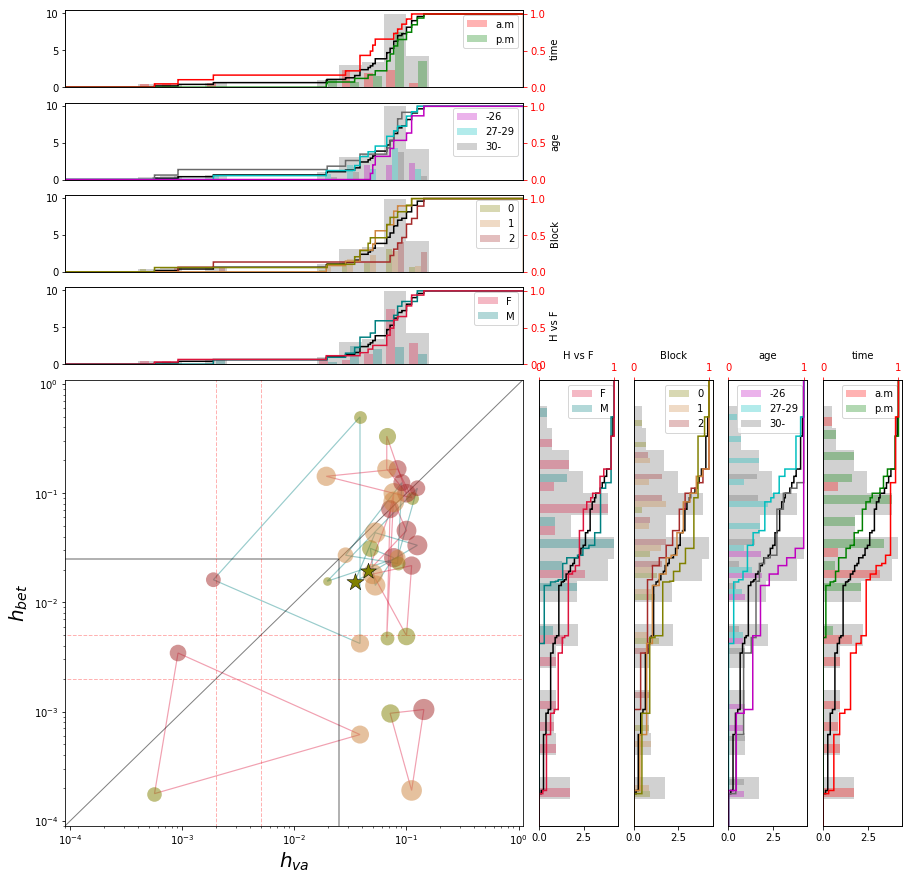



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1756		0.3430		0.2886
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0214		0.0400		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995
AGE -26 vs 27-29 :	0.0846		0.1600		0.2653
AGE -26 vs 30- :	0.0826		0.1547		0.2681
AGE 27-29 vs 30- :	0.3388		0.6598		0.9059
TIME a.m vs p.m :	0.0206		0.0397		0.0582

Significatif : ['BLOCK 0 vs 2', 'BLOCK 1 vs 2', 'TIME a.m vs p.m']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.1039		0.2013		0.1920
BLOCK 0 vs 1 :		0.4145		0.8050		0.9992
BLOCK 0 vs 2 :		0.0024		0.0042		0.0112
BLOCK 1 vs 2 :		0.0008		0.0015		0.0067
AGE -26 vs 27-29 :	0.1212		0.2300		0.3759
AGE -26 vs 30- :	0.1952		0.3683		0.5386
AGE 27-29 vs 30- :	0.4883		0.9532		0.9675
TIME a.m vs p.m 

In [12]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

---------------------------------

In [13]:
file = os.path.join('parametre', 'list_h_block_Scalling_sujet.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

AM BMC CS DC FM IP LB OP RS SR TN YK 

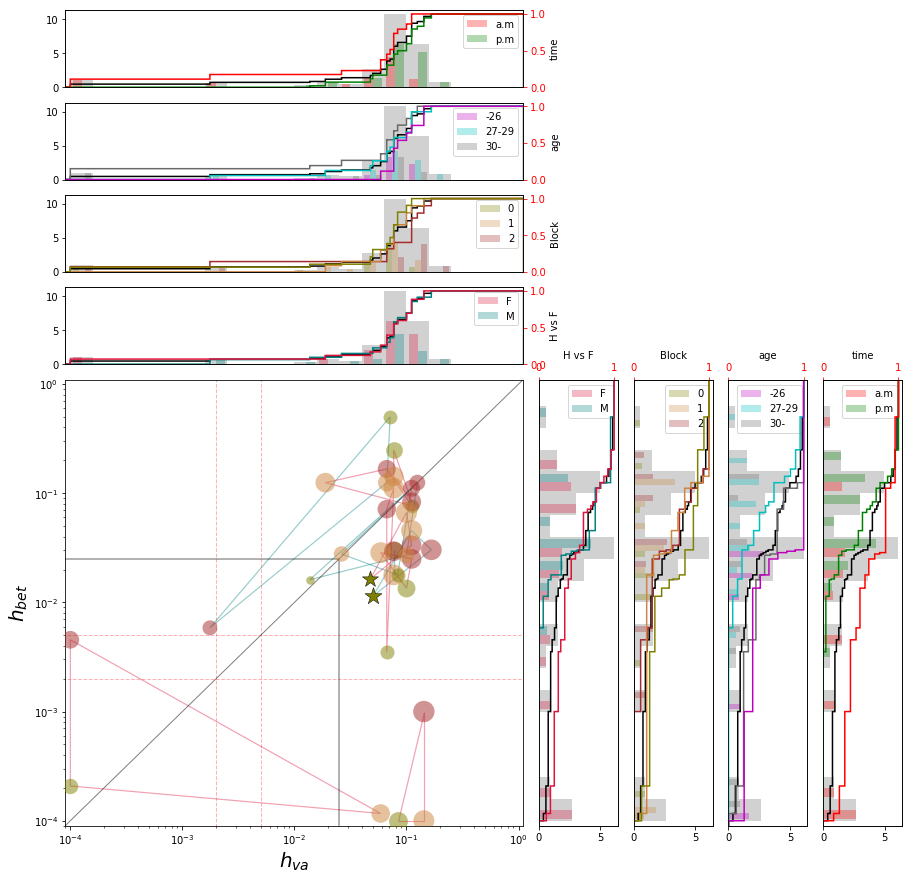



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4807		0.9485		0.9999
BLOCK 0 vs 1 :		0.2905		0.5613		0.9985
BLOCK 0 vs 2 :		0.0583		0.1100		0.0995
BLOCK 1 vs 2 :		0.1282		0.2444		0.2558
AGE -26 vs 27-29 :	0.1327		0.2528		0.3936
AGE -26 vs 30- :	0.0370		0.0684		0.1590
AGE 27-29 vs 30- :	0.1632		0.3145		0.9059
TIME a.m vs p.m :	0.0341		0.0659		0.4374

Significatif : ['AGE -26 vs 30-', 'TIME a.m vs p.m']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4562		0.8978		0.9994
BLOCK 0 vs 1 :		0.4141		0.8042		0.9932
BLOCK 0 vs 2 :		0.0104		0.0190		0.0303
BLOCK 1 vs 2 :		0.0179		0.0330		0.0617
AGE -26 vs 27-29 :	0.1863		0.3559		0.5199
AGE -26 vs 30- :	0.0941		0.1749		0.3429
AGE 27-29 vs 30- :	0.2776		0.5356		0.9916
TIME a.m vs p.m :	0.1730		0.33

In [14]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None)

AM BMC CS DC FM IP LB OP RS SR TN YK 

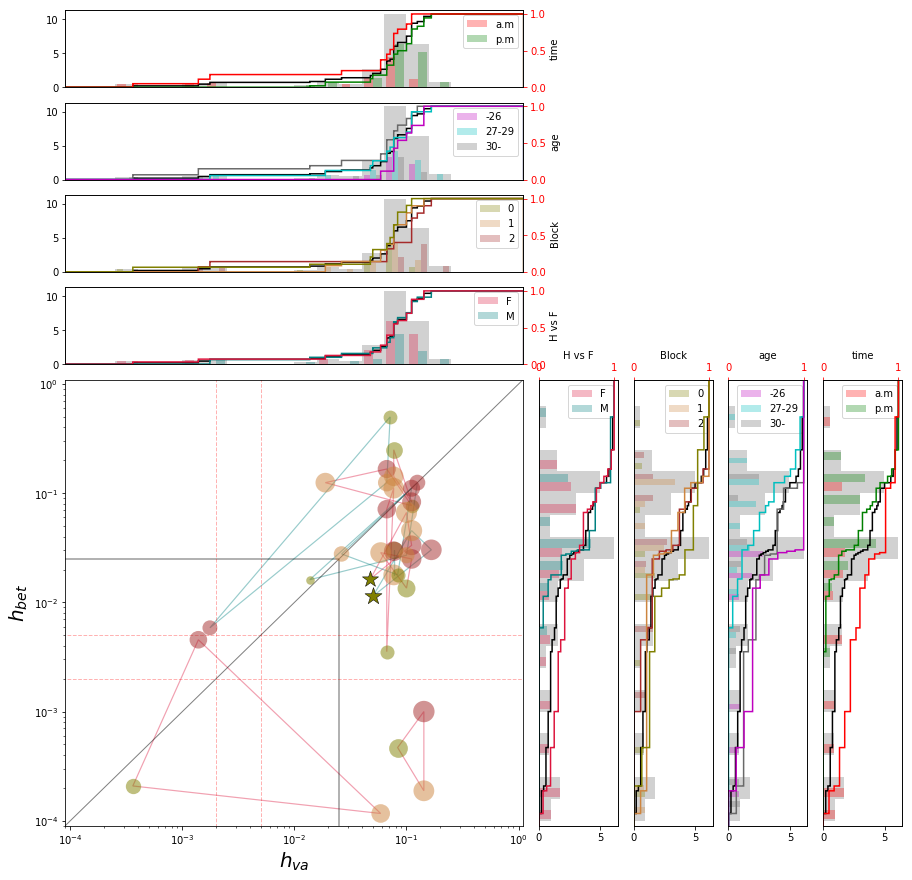



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4807		0.9485		0.9999
BLOCK 0 vs 1 :		0.2905		0.5613		0.9985
BLOCK 0 vs 2 :		0.0550		0.1038		0.0995
BLOCK 1 vs 2 :		0.1282		0.2444		0.2558
AGE -26 vs 27-29 :	0.1327		0.2528		0.3936
AGE -26 vs 30- :	0.0371		0.0685		0.1590
AGE 27-29 vs 30- :	0.1633		0.3146		0.9059
TIME a.m vs p.m :	0.0341		0.0659		0.4374

Significatif : ['AGE -26 vs 30-', 'TIME a.m vs p.m']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4562		0.8978		0.9994
BLOCK 0 vs 1 :		0.4141		0.8042		0.9932
BLOCK 0 vs 2 :		0.0104		0.0190		0.0303
BLOCK 1 vs 2 :		0.0179		0.0330		0.0617
AGE -26 vs 27-29 :	0.1863		0.3559		0.5199
AGE -26 vs 30- :	0.0941		0.1749		0.3429
AGE 27-29 vs 30- :	0.2776		0.5356		0.9916
TIME a.m vs p.m :	0.1730		0.33

In [15]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

---------------------------------

In [16]:
file = os.path.join('parametre', 'list_h_block_Scalling_full.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

AM BMC CS DC FM IP LB OP RS SR TN YK 

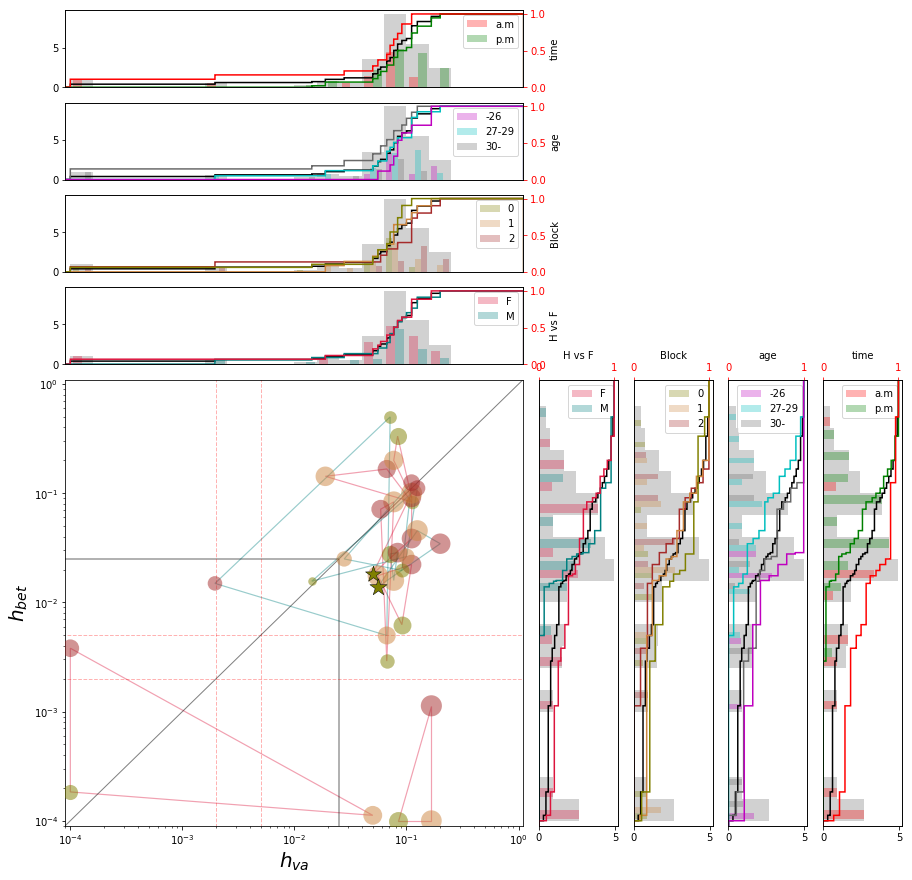



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4297		0.8468		0.9996
BLOCK 0 vs 1 :		0.2912		0.5628		0.8690
BLOCK 0 vs 2 :		0.0551		0.1038		0.0995
BLOCK 1 vs 2 :		0.1764		0.3379		0.5361
AGE -26 vs 27-29 :	0.1921		0.3681		0.6408
AGE -26 vs 30- :	0.0437		0.0811		0.1590
AGE 27-29 vs 30- :	0.1103		0.2114		0.7863
TIME a.m vs p.m :	0.0248		0.0477		0.2036

Significatif : ['AGE -26 vs 30-', 'TIME a.m vs p.m']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.5000		0.9854		0.9994
BLOCK 0 vs 1 :		0.4145		0.8050		0.7771
BLOCK 0 vs 2 :		0.0095		0.0173		0.0303
BLOCK 1 vs 2 :		0.0314		0.0583		0.1342
AGE -26 vs 27-29 :	0.2629		0.5053		0.7943
AGE -26 vs 30- :	0.1098		0.2047		0.3429
AGE 27-29 vs 30- :	0.1885		0.3613		0.8487
TIME a.m vs p.m :	0.1337		0.25

In [17]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None)

AM BMC CS DC FM IP LB OP RS SR TN YK 

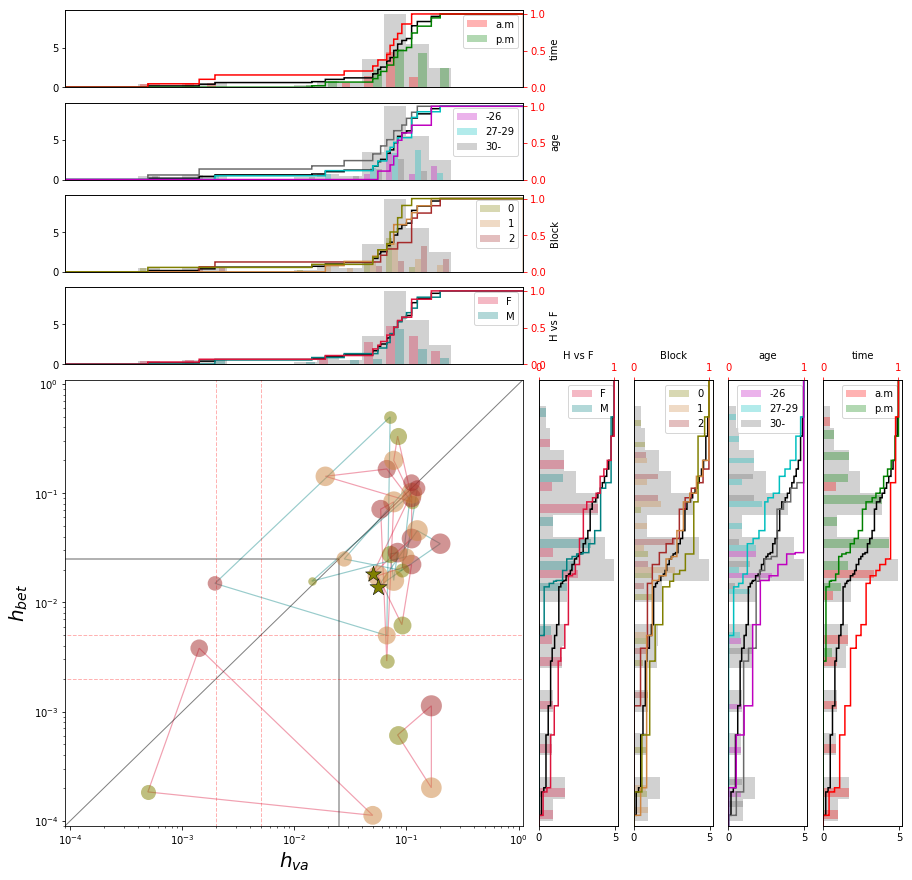



----------------------------------------------------------------
h_va
----------------------------------------------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.4297		0.8468		0.9996
BLOCK 0 vs 1 :		0.2912		0.5628		0.8690
BLOCK 0 vs 2 :		0.0520		0.0979		0.0995
BLOCK 1 vs 2 :		0.1764		0.3379		0.5361
AGE -26 vs 27-29 :	0.1921		0.3681		0.6408
AGE -26 vs 30- :	0.0438		0.0812		0.1590
AGE 27-29 vs 30- :	0.1103		0.2115		0.7863
TIME a.m vs p.m :	0.0248		0.0477		0.2036

Significatif : ['AGE -26 vs 30-', 'TIME a.m vs p.m']


Coupe à h=0.002, tau=500
------------------------

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
H vs F :		0.5000		0.9854		0.9994
BLOCK 0 vs 1 :		0.4145		0.8050		0.7771
BLOCK 0 vs 2 :		0.0095		0.0173		0.0303
BLOCK 1 vs 2 :		0.0314		0.0583		0.1342
AGE -26 vs 27-29 :	0.2629		0.5053		0.7943
AGE -26 vs 30- :	0.1098		0.2047		0.3429
AGE 27-29 vs 30- :	0.1885		0.3613		0.8487
TIME a.m vs p.m :	0.1337		0.25

In [18]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

---------------------------------

---------------------------------